## Load parquet

In [1]:
%matplotlib widget
%matplotlib inline

In [2]:

import pandas as pd

import matplotlib.pyplot as plt
import pandas_ta as ta

In [3]:
df = pd.read_parquet("data.parquet").sort_values("ts")

In [4]:
df.head()

,name,id,figi,ts,open_price,close_price,high_price,low_price,volume
117310,Tiffany & Co,421,BBG000BV75B7,2018-01-23 07:02:00+00:00,110.11,110.11,110.11,110.11,10.0
9010,General Electric Company,30,BBG000BK6MB5,2018-01-23 07:04:00+00:00,16.20,16.24,16.24,16.20,158.0
10137,Procter & Gamble,36,BBG000BR2TH3,2018-01-23 07:07:00+00:00,92.31,92.31,92.31,92.31,5.0
9009,General Electric Company,30,BBG000BK6MB5,2018-01-23 07:09:00+00:00,16.24,16.24,16.24,16.24,21.0
9008,General Electric Company,30,BBG000BK6MB5,2018-01-23 07:15:00+00:00,16.23,16.23,16.23,16.23,50.0


In [24]:
df.groupby("name").count()

,id,figi,ts,open_price,close_price,high_price,low_price,volume
name,,,,,,,,
Alfa Bank,1,1,1,1,1,1,1,1
Rosneft,1,1,1,1,1,1,1,1
Gazprom,36,36,36,36,36,36,36,36
Coty,622,622,622,622,622,622,622,622
Foot Locker,784,784,784,784,784,784,784,784
...,...,...,...,...,...,...,...,...
Dollar Tree,28432,28432,28432,28432,28432,28432,28432,28432
Microchip Technology,28646,28646,28646,28646,28646,28646,28646,28646
Altria Group,28788,28788,28788,28788,28788,28788,28788,28788


## Analyze single stock

### Create dataset with sliding averages

In [6]:
sliding_window_df = df[df["id"] == 1].reset_index()

In [7]:
sliding_window_df.head()

,index,name,id,figi,ts,open_price,close_price,high_price,low_price,volume
0,401,JPMorgan,1,BBG000DMBXR2,2018-01-23 11:07:00+00:00,114.50,114.50,114.50,114.50,1.0
1,400,JPMorgan,1,BBG000DMBXR2,2018-01-23 11:12:00+00:00,114.27,114.27,114.27,114.27,2.0
2,399,JPMorgan,1,BBG000DMBXR2,2018-01-23 13:43:00+00:00,114.00,114.00,114.00,114.00,18.0
3,398,JPMorgan,1,BBG000DMBXR2,2018-01-23 13:45:00+00:00,114.00,114.00,114.00,114.00,882.0
4,397,JPMorgan,1,BBG000DMBXR2,2018-01-23 13:50:00+00:00,113.82,113.82,113.82,113.82,100.0


In [8]:

# List of all indicators
sliding_window_df.ta.indicators()


Pandas TA - Technical Analysis Indicators - v0.2.23b0
Total Indicators: 123
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_doji, cdl_inside, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, decay, decreasing, dema, donchian, dpo, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, ichimoku, increasing, inertia, kama, kc, kdj, kst, kurtosis, linreg, log_return, long_run, macd, mad, massi, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvt, pwma, qstick, quantile, rma, roc, rsi, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, stdev, stoch, stochrsi, supertrend, swma, t3, tema, thermo, trend_return, trima, trix, true_range, tsi, ttm_trend, ui, uo, variance, vortex, vp, vwap, vwma, wcp, willr, wma, zlma, zscore


In [9]:
def preprocess_data(df):
    # Add MACD
    df.ta.macd(append=True)

    # Add RSI
    df.ta.rsi(append=True)

    # Rename columns
    df = df.rename(columns={
        "MACD_12_26_9": "MACD",
        "MACDs_12_26_9": "MACDs",
        "MACDh_12_26_9": "MACDh",
        "RSI_14": "RSI"})

    # Calc RSI signals
    RSI_oversold_threshold = 30
    RSI_overbouht_threshold = 70

    df["RSI_oversold"] = df["RSI"] <= RSI_oversold_threshold
    df["RSI_overbought"] = df["RSI"] >= RSI_overbouht_threshold

    df["MACD_crossover"] = (df["MACDh"] > 0) & (df["MACDh"].shift() <= 0)
    df["MACD_crossunder"] = (df["MACDh"] <= 0) & (df["MACDh"].shift() > 0)

    return df

In [10]:
sliding_window_df = preprocess_data(sliding_window_df)
sliding_window_df.head()

,index,name,id,figi,ts,open_price,close_price,high_price,low_price,volume,MACD,MACDh,MACDs,RSI,RSI_oversold,RSI_overbought,MACD_crossover,MACD_crossunder
0,401,JPMorgan,1,BBG000DMBXR2,2018-01-23 11:07:00+00:00,114.50,114.50,114.50,114.50,1.0,NaN,NaN,NaN,NaN,False,False,False,False
1,400,JPMorgan,1,BBG000DMBXR2,2018-01-23 11:12:00+00:00,114.27,114.27,114.27,114.27,2.0,NaN,NaN,NaN,0.0,True,False,False,False
2,399,JPMorgan,1,BBG000DMBXR2,2018-01-23 13:43:00+00:00,114.00,114.00,114.00,114.00,18.0,NaN,NaN,NaN,0.0,True,False,False,False
3,398,JPMorgan,1,BBG000DMBXR2,2018-01-23 13:45:00+00:00,114.00,114.00,114.00,114.00,882.0,NaN,NaN,NaN,0.0,True,False,False,False
4,397,JPMorgan,1,BBG000DMBXR2,2018-01-23 13:50:00+00:00,113.82,113.82,113.82,113.82,100.0,NaN,NaN,NaN,0.0,True,False,False,False


Show MACD RSI

In [11]:
def color_zone(ax, points, alpha, color):
    start_point = 0
    end_point = 0
    for x in points:
        if start_point == 0:
            start_point = x
            end_point = x + 1
        else:
            if end_point == x:
                # Continue
                end_point += 1
            else:
                # Draw and reset
                ax.axvspan(start_point, end_point, alpha=alpha, color=color)
                start_point = 0
                end_point = 0
    
    if start_point != 0:
        # Draw and reset
        ax.axvspan(start_point, end_point, alpha=alpha, color=color)
        start_point = 0
        end_point = 0

In [12]:
def plot_candles(df):
    width=1
    width2=0.2

    pricesup = df[df["close_price"] >= df["open_price"]]
    pricesdown = df[df["close_price"] < df["open_price"]]

    plt.bar(pricesup.index, pricesup["close_price"] - pricesup["open_price"], width, bottom=pricesup["open_price"], color='g')
    plt.bar(pricesup.index, pricesup["high_price"] - pricesup["close_price"], width2, bottom=pricesup["close_price"], color='g')
    plt.bar(pricesup.index, pricesup["low_price"] - pricesup["open_price"], width2, bottom=pricesup["open_price"], color='g')

    plt.bar(pricesdown.index, pricesdown["close_price"] - pricesdown["open_price"], width, bottom=pricesdown["open_price"], color='r')
    plt.bar(pricesdown.index, pricesdown["high_price"] - pricesdown["close_price"], width2, bottom=pricesdown["close_price"], color='r')
    plt.bar(pricesdown.index, pricesdown["low_price"] - pricesdown["open_price"], width2, bottom=pricesdown["open_price"], color='r')
    plt.grid()

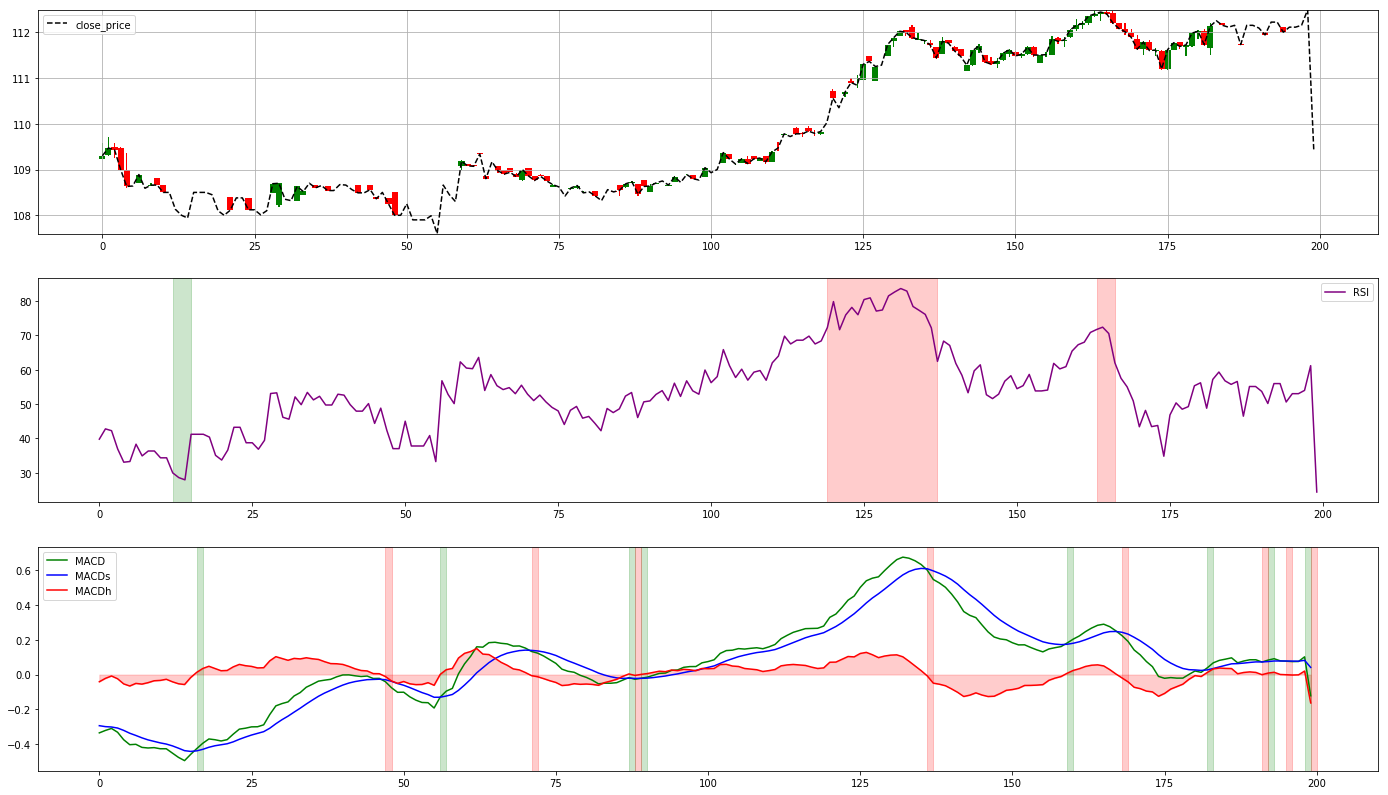

In [13]:
plot_df = sliding_window_df.iloc[600:800].reset_index()

plt.figure(figsize=(24,14))
plt.subplot(3, 1, 1)
plot_df["close_price"].plot(color="black", linestyle='--')
plot_candles(plot_df)
plt.legend()

plt.subplot(3, 1, 2)
ax1 = plot_df["RSI"].plot(color="purple")
# Show oversold zone
color_zone(ax1, plot_df[plot_df["RSI_oversold"]].index, 0.2, "green")
# Show overbought zone
color_zone(ax1, plot_df[plot_df["RSI_overbought"]].index, 0.2, "red")
plt.legend()

plt.subplot(3, 1, 3)
ax3 = plot_df["MACD"].plot(color="green")
plot_df["MACDs"].plot(ax=ax3,color="blue")
plot_df["MACDh"].plot(ax=ax3,color="red")
ax3.fill_between(plot_df.index, plot_df["MACDh"], alpha=0.2, color="red")
# Show crossover moments
for x in plot_df[plot_df["MACD_crossover"]].index:
    ax3.axvspan(x, x+1, alpha=0.2, color="green")      
# Show crossunder moments
for x in plot_df[plot_df["MACD_crossunder"]].index:
    ax3.axvspan(x, x+1, alpha=0.2, color="red")
plt.legend()

# Create manual bot

In [14]:
# Create dataset for bot
bot_df = sliding_window_df[["open_price","close_price","high_price","low_price","volume","MACD","RSI"]]
bot_df.head()

,open_price,close_price,high_price,low_price,volume,MACD,RSI
0,114.50,114.50,114.50,114.50,1.0,NaN,NaN
1,114.27,114.27,114.27,114.27,2.0,NaN,0.0
2,114.00,114.00,114.00,114.00,18.0,NaN,0.0
3,114.00,114.00,114.00,114.00,882.0,NaN,0.0
4,113.82,113.82,113.82,113.82,100.0,NaN,0.0


In [15]:
from bot import TradingBot

# Test bot
bot = TradingBot(stop_loss=0.02)

bot.reset()

for index, data in bot_df.iterrows():
    bot.process(data)

bot.profit * 100

2.9165267584840637

# Test bot on different stocks

In [16]:
def test_bot_profit(df):
    # Preprocess data
    bot_df = preprocess_data(df)
    # Select columns
    bot_df = bot_df[["open_price","close_price","high_price","low_price","volume","MACD","RSI"]]

    # Create bot instance
    bot = TradingBot(stop_loss=0.02)
    # Reset bot
    bot.reset()
    # Run bot
    for index, data in bot_df.iterrows():
        bot.process(data)

    return bot.profit * 100

In [21]:
bot_profit_df = pd.DataFrame()

for stock_name, stock_df in df.groupby("name"):
    # Check size of dataset
    if stock_df.shape[0] > 8 * 60:
        profit = test_bot_profit(stock_df)

        bot_profit_df = bot_profit_df.append({"name":stock_name,"profit":profit}, ignore_index=True)

bot_profit_df

,name,profit
0,AT&T,9.763074
1,AbbVie,1.472849
2,Accenture,0.701481
3,Activision Blizzard,4.035399
4,Adobe,21.106348
...,...,...
338,Xylem,5.272801
339,Zimmer Biomet Holdings,-0.464336
340,Zions Bancorporation,1.393696
341,Zoetis,15.076332


In [22]:
bot_profit_df.sort_values("profit")

,name,profit
309,VEON,-18.086126
303,United Airlines Holdings,-15.557540
49,BlackRock,-14.980382
280,Stanley Black & Decker,-14.594801
256,Qualcomm,-12.098348
...,...,...
18,Amazon.com,23.157325
217,NRG Energy,24.336088
186,Lam Research,26.090822
321,WW Grainger,26.226690
